In [1]:
import os


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"] = "0";
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from model import U_net, BU_net
from custom_loss import Weighted_BCEnDice_loss
from custom_metric import mean_iou, dice_coef

In [2]:
# Loading the data
X_train = np.load('/home/user01/data_ssd/Talha/brats/X_train_norm_resized.npy')
X_valid = np.load('/home/user01/data_ssd/Talha/brats/X_test_norm_resized.npy') 
Y_train = np.load('/home/user01/data_ssd/Talha/brats/Y_train_norm_resized.npy') 
Y_valid = np.load('/home/user01/data_ssd/Talha/brats/Y_test_norm_resized.npy') 
 

In [3]:
im_width = 256
im_height = 256
batch_size = 8
input_img = Input((im_height, im_width, 4), name='img')
model = BU_net(input_img, n_filters=64, dropout=0.3, batchnorm=True)
model.compile(optimizer=Adam(), loss = Weighted_BCEnDice_loss, metrics = [mean_iou, dice_coef])
model.summary()
callbacks = [
    EarlyStopping(patience=10, verbose=1), #Early Stopping if loss is not reduced since 10 Epochs
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),  #Decay LR if loss is not reduced since 5 Epochs
    ModelCheckpoint('/home/user01/data_ssd/Talha/brats/bu_net.h5', verbose=1, save_best_only=True, save_weights_only=True) # Save weights if val loss is improved
]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 12608       img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
results = model.fit(X_train, Y_train, batch_size=batch_size, epochs=50, callbacks=callbacks,validation_data=(X_valid, Y_valid))


Train on 259 samples, validate on 76 samples
Epoch 1/50
256/259 [============================>.] - ETA: 0s - loss: 0.3647 - mean_iou: 0.3438 - dice_coef: 0.7694
Epoch 00001: val_loss improved from inf to 1.50222, saving model to /home/user01/data_ssd/Talha/brats/bu_net.h5
259/259 [==============================] - 51s 196ms/sample - loss: 0.3629 - mean_iou: 0.3459 - dice_coef: 0.7729 - val_loss: 1.5022 - val_mean_iou: 0.2137 - val_dice_coef: 0.4771
Epoch 2/50
256/259 [============================>.] - ETA: 0s - loss: 0.2462 - mean_iou: 0.3850 - dice_coef: 0.8769
Epoch 00002: val_loss improved from 1.50222 to 1.09506, saving model to /home/user01/data_ssd/Talha/brats/bu_net.h5
259/259 [==============================] - 35s 134ms/sample - loss: 0.2459 - mean_iou: 0.3855 - dice_coef: 0.8768 - val_loss: 1.0951 - val_mean_iou: 0.1742 - val_dice_coef: 0.4443
Epoch 3/50
256/259 [============================>.] - ETA: 0s - loss: 0.2180 - mean_iou: 0.4192 - dice_coef: 0.8958
Epoch 00003: val_lo

259/259 [==============================] - 36s 138ms/sample - loss: 0.1316 - mean_iou: 0.5699 - dice_coef: 0.9458 - val_loss: 0.2466 - val_mean_iou: 0.4172 - val_dice_coef: 0.8936
Epoch 23/50
256/259 [============================>.] - ETA: 0s - loss: 0.1304 - mean_iou: 0.5754 - dice_coef: 0.9455
Epoch 00023: val_loss improved from 0.24655 to 0.23620, saving model to /home/user01/data_ssd/Talha/brats/bu_net.h5
259/259 [==============================] - 36s 139ms/sample - loss: 0.1310 - mean_iou: 0.5742 - dice_coef: 0.9453 - val_loss: 0.2362 - val_mean_iou: 0.4307 - val_dice_coef: 0.9051
Epoch 24/50
256/259 [============================>.] - ETA: 0s - loss: 0.1300 - mean_iou: 0.5760 - dice_coef: 0.9463
Epoch 00024: val_loss improved from 0.23620 to 0.23521, saving model to /home/user01/data_ssd/Talha/brats/bu_net.h5
259/259 [==============================] - 36s 138ms/sample - loss: 0.1298 - mean_iou: 0.5761 - dice_coef: 0.9464 - val_loss: 0.2352 - val_mean_iou: 0.4350 - val_dice_coef: 0

In [5]:
# Evaluate model
model.evaluate(X_valid, Y_valid, verbose=1)# gives accuracy and loss as specified

76/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.24209656840876528, 0.43345514, 0.8995958]

In [6]:
# Save the trained model
# model.save_weights('/home/user01/data_ssd/Talha/brats/bu_net.h5')
# load the best model
# model.load_weights('/home/user01/data_ssd/Talha/brats/bu_net.h5')

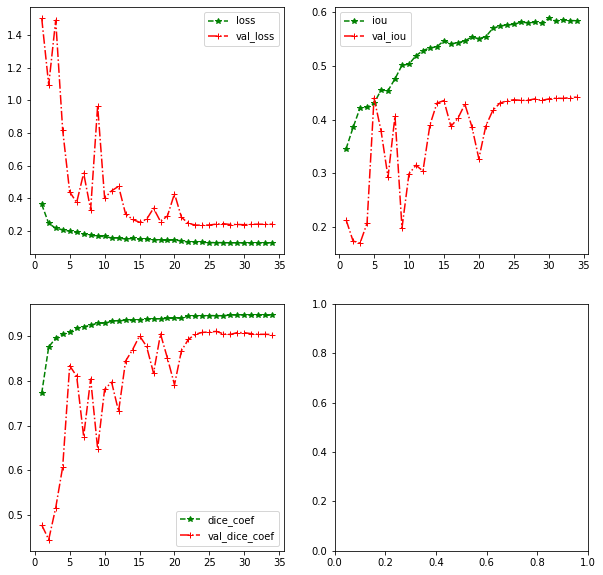

In [7]:
f, ax = plt.subplots(2, 2, figsize = (10,10), sharex=False)
        
x = np.arange(len(results.history["val_loss"])) + 1 

#ax1.set_yscale('log')
ax[0,0].plot(x, results.history["loss"], 'g--*', label="loss")
ax[0,0].plot(x, results.history["val_loss"], 'r-.+', label="val_loss")
ax[0,0].legend()

ax[0,1].plot(x, results.history["mean_iou"], 'g--*', label='iou')
ax[0,1].plot(x, results.history["val_mean_iou"], 'r-.+', label="val_iou")
ax[0,1].legend()

ax[1,0].plot(x, results.history["dice_coef"], 'g--*', label='dice_coef')
ax[1,0].plot(x, results.history["val_dice_coef"], 'r-.+', label="val_dice_coef")
ax[1,0].legend()

plt.show();

1/1 [==============================] - 2s 2s/sample


Text(0.5, 1.0, 'Flair')

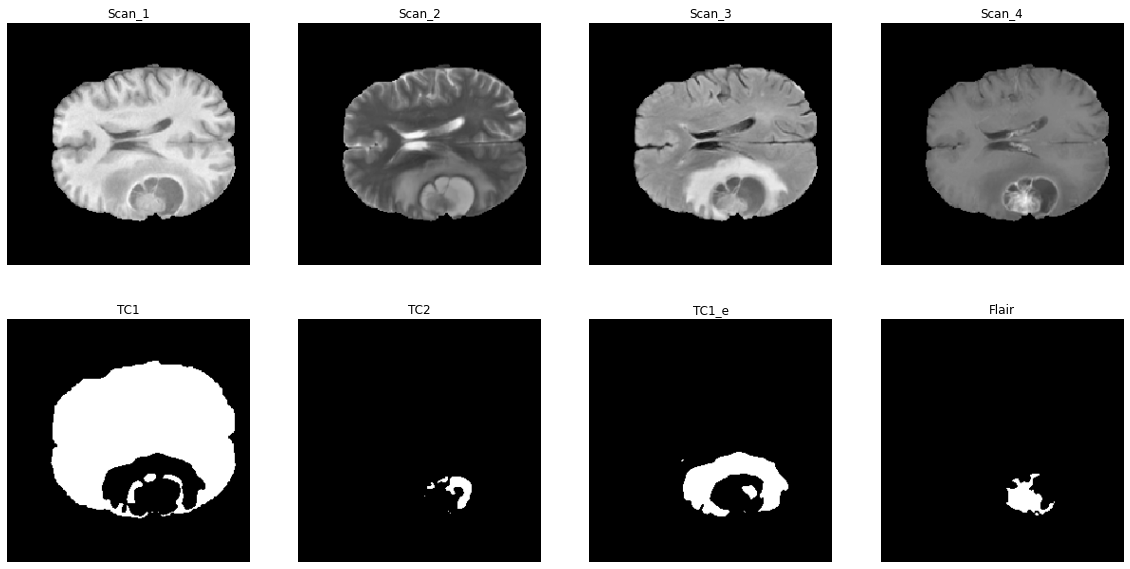

In [8]:
index = 18
temp1 = X_train[index]
temp2 = temp1[np.newaxis,:,:,:]

preds_train = np.squeeze(model.predict(temp2, verbose=1))
preds_train = (preds_train > 0.2).astype(np.uint8)

#%
fig, ax = plt.subplots(2, 4, figsize = (20, 10))

ax[0,0].imshow(temp1[...,0], cmap = 'gray', interpolation = 'bilinear')
ax[0,0].axis("off")
ax[0,0].set_title('Scan_1')

ax[0,1].imshow(temp1[...,1], cmap = 'gray', interpolation = 'bilinear')
ax[0,1].axis("off")
ax[0,1].set_title('Scan_2')

ax[0,2].imshow(temp1[...,2], cmap = 'gray', interpolation = 'bilinear')
ax[0,2].axis("off")
ax[0,2].set_title('Scan_3')

ax[0,3].imshow(temp1[...,3], cmap = 'gray', interpolation = 'bilinear')
ax[0,3].axis("off")
ax[0,3].set_title('Scan_4')

ax[1,0].imshow(preds_train[..., 1], cmap = 'gray', interpolation = 'bilinear')
ax[1,0].axis("off")
ax[1,0].set_title('TC1')

ax[1,1].imshow(preds_train[..., 2], cmap = 'gray', interpolation = 'bilinear')
ax[1,1].axis("off")
ax[1,1].set_title('TC2')

ax[1,2].imshow(preds_train[..., 3], cmap = 'gray', interpolation = 'bilinear')
ax[1,2].axis("off")
ax[1,2].set_title('TC1_e')

ax[1,3].imshow(preds_train[..., 4], cmap = 'gray', interpolation = 'bilinear')
ax[1,3].axis("off")
ax[1,3].set_title('Flair')


Text(0.5, 1.0, 'Pred')

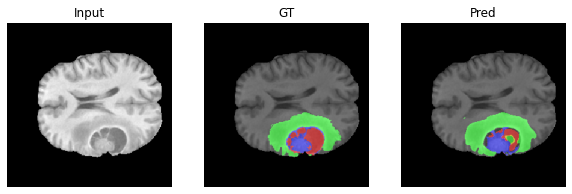

In [9]:
import cv2
alpha = 0.5
beta = (1.0 - alpha)
# Combined overlayed results
ip = X_train[index,:,:,0]
ip = cv2.merge((ip, ip, ip)) # make 3 channels for merging
gt = Y_train[index,:,:,2:5].astype(np.float64)
preds = preds_train[:,:,2:5].astype(np.float64)

o_gt = cv2.addWeighted(ip, alpha, gt, beta, 0.0)
o_pred = cv2.addWeighted(ip, alpha, preds, beta, 0.0)

fig, ax = plt.subplots(1, 3, figsize = (10, 5))

ax[0].imshow(ip)
ax[0].axis("off")
ax[0].set_title('Input')

ax[1].imshow(o_gt)
ax[1].axis("off")
ax[1].set_title('GT')

ax[2].imshow(o_pred)
ax[2].axis("off")
ax[2].set_title('Pred')

In [11]:
# Save the whole model in .h5 file
tf.keras.models.save_model(model, filepath='/home/user01/data_ssd/Talha/brats/brats_model.h5')

In [14]:
# Before loading the model first define the custom objects you embedded in model
# Also remember you
cl = { 'Weighted_BCEnDice_loss' : Weighted_BCEnDice_loss,
      'mean_iou': mean_iou,
      'dice_coef': dice_coef}
# Now load model
loaded_model = tf.keras.models.load_model(filepath='/home/user01/data_ssd/Talha/brats/brats_model.h5',
                                          custom_objects=cl, compile=True) 
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 12608       img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

1/1 [==============================] - 0s 84ms/sample


Text(0.5, 1.0, 'Pred')

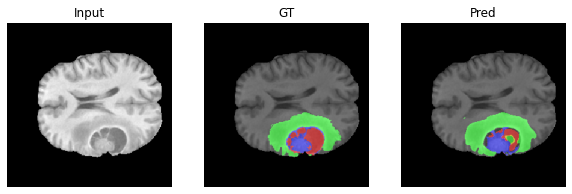

In [16]:
# now predict via loaded model
preds_train_loaded = np.squeeze(loaded_model.predict(temp2, verbose=1))
preds_train = (preds_train_loaded > 0.2).astype(np.uint8)

ip = X_train[index,:,:,0]
ip = cv2.merge((ip, ip, ip)) # make 3 channels for merging
gt = Y_train[index,:,:,2:5].astype(np.float64)
preds = preds_train[:,:,2:5].astype(np.float64)

o_gt = cv2.addWeighted(ip, alpha, gt, beta, 0.0)
o_pred = cv2.addWeighted(ip, alpha, preds, beta, 0.0)

fig, ax = plt.subplots(1, 3, figsize = (10, 5))

ax[0].imshow(ip)
ax[0].axis("off")
ax[0].set_title('Input')

ax[1].imshow(o_gt)
ax[1].axis("off")
ax[1].set_title('GT')

ax[2].imshow(o_pred)
ax[2].axis("off")
ax[2].set_title('Pred')